# Load Data

In [96]:
import os
from google.colab import drive
import urllib.request
import zipfile
from IPython.display import clear_output

os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/kaggle"

In [97]:
# Mount Google Drive
drive.mount('/content/drive')

# Path to data directory in Google Drive
data_dir = "/content/drive/MyDrive/bird_classification/data"

# Create data directory if it doesn't exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Download and extract the dataset if it doesn't exist
if not os.path.exists(os.path.join(data_dir, 'data')):
  !kaggle datasets download -d gpiosenka/100-bird-species -p /content/drive/MyDrive/bird_classification/data
  !unzip /content/drive/MyDrive/bird_classification/data/100-bird-species.zip -d /content/drive/MyDrive/bird_classification/data

# Clear the output
clear_output(wait=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
100-bird-species.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/drive/MyDrive/bird_classification/data/100-bird-species.zip
replace /content/drive/MyDrive/bird_classification/data/EfficientNetB0-515-(224 X 224)- 98.95.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# EDA

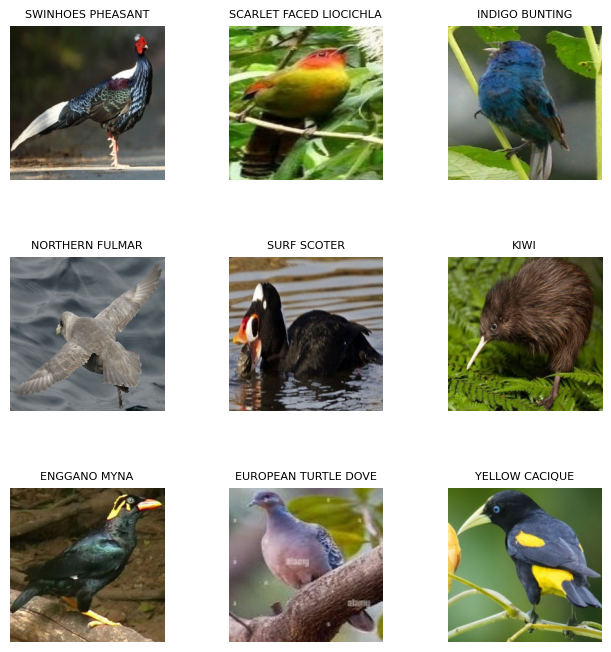

In [139]:
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

# define paths to bird images and labels
data_dir = "/content/drive/MyDrive/bird_classification/data/"
train_dir = os.path.join(data_dir, 'train')
classes = os.listdir(train_dir)

# create a 3x3 grid of bird images and labels
fig, axs = plt.subplots(3, 3, figsize=(8,8))
fig.subplots_adjust(hspace=.5)

# iterate over the grid and randomly select a bird image for each subplot
for i in range(3):
    for j in range(3):
        # select a random class and image from that class
        bird_class = random.choice(classes)
        img_path = os.path.join(train_dir, bird_class, random.choice(os.listdir(os.path.join(train_dir, bird_class))))
        
        # load and display the image
        img = Image.open(img_path)
        axs[i,j].imshow(img)
        axs[i,j].axis('off')
        
        # display the label
        axs[i,j].set_title(bird_class, fontsize=8)

plt.show()


# Model

In [140]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import os
from torchvision import datasets, models, transforms

device = "mps" if getattr(torch,'has_mps',False) \
    else "cuda" if torch.cuda.is_available() else "cpu"

print(device)

cuda


In [141]:
# Define transforms for the training data and testing data
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize the image
])

In [142]:
# Load the datasets with ImageFolder
data_dir = "/content/drive/MyDrive/bird_classification/data/"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform) for x in ['train', 'valid', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'valid', 'test']}

In [111]:
# Load pretrained ResNet50 model
model = models.resnet50(pretrained=True)

# Modify the last layer of the model
num_classes = len(image_datasets['train'].classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [112]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [113]:
from tqdm import tqdm

num_epochs = 20
train_losses = dict()
train_acc = dict()
valid_losses = dict()
valid_acc = dict()

for epoch in range(num_epochs):
  # Train the model
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in dataloaders['train']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    
    model = model.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  epoch_loss = running_loss / len(dataloaders['train'])
  epoch_acc = correct / total
  train_losses[epoch] = epoch_loss
  train_acc[epoch] = epoch_acc
  print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}'.format(epoch+1, num_epochs, epoch_loss, epoch_acc))

  # Evaluate the model on validation data
  running_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
    for inputs, labels in dataloaders['valid']:
      inputs = inputs.to(device)
      labels = labels.to(device)

      model = model.to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      loss = criterion(outputs, labels)
      running_loss += loss.item()

  epoch_loss = running_loss / len(dataloaders['valid'])
  epoch_acc = correct / total
  valid_losses[epoch] = epoch_loss
  valid_acc[epoch] = epoch_acc
  print('Epoch [{}/{}], Valid Loss: {:.4f}, Valid Acc: {:.4f}'.format(epoch+1, num_epochs, epoch_loss, epoch_acc))



Epoch [1/20], Train Loss: 4.7801, Train Acc: 0.1014
Epoch [1/20], Valid Loss: 2.7269, Valid Acc: 0.3720
Epoch [2/20], Train Loss: 2.0951, Train Acc: 0.5076
Epoch [2/20], Valid Loss: 1.2546, Valid Acc: 0.6847
Epoch [3/20], Train Loss: 1.2062, Train Acc: 0.7011
Epoch [3/20], Valid Loss: 0.8354, Valid Acc: 0.7868
Epoch [4/20], Train Loss: 0.8332, Train Acc: 0.7878
Epoch [4/20], Valid Loss: 0.6208, Valid Acc: 0.8439
Epoch [5/20], Train Loss: 0.6085, Train Acc: 0.8409
Epoch [5/20], Valid Loss: 0.5323, Valid Acc: 0.8497
Epoch [6/20], Train Loss: 0.4620, Train Acc: 0.8751
Epoch [6/20], Valid Loss: 0.4800, Valid Acc: 0.8703
Epoch [7/20], Train Loss: 0.3514, Train Acc: 0.9031
Epoch [7/20], Valid Loss: 0.4433, Valid Acc: 0.8831
Epoch [8/20], Train Loss: 0.2698, Train Acc: 0.9231
Epoch [8/20], Valid Loss: 0.4225, Valid Acc: 0.8909
Epoch [9/20], Train Loss: 0.2118, Train Acc: 0.9382
Epoch [9/20], Valid Loss: 0.4267, Valid Acc: 0.8889
Epoch [10/20], Train Loss: 0.1696, Train Acc: 0.9498
Epoch [10/2

In [114]:
# Save the model
export_dir = "/content/drive/MyDrive/bird_classification/"
torch.save(model.state_dict(), export_dir +'model.ckpt')    

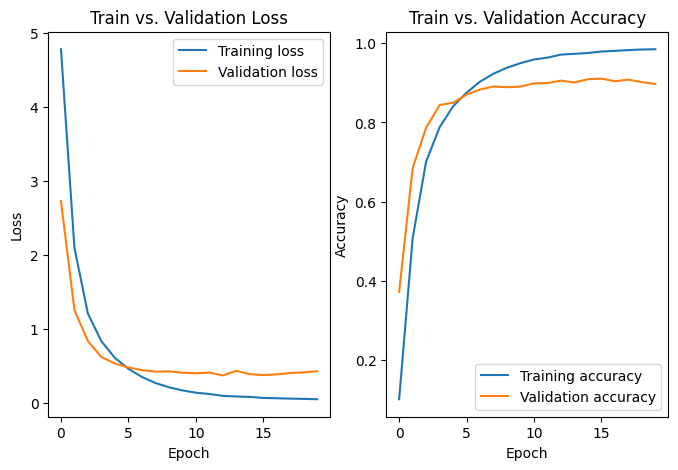

In [116]:
# Plot training and validation loss
# create lists to store training and validation loss
train_loss_list = []
valid_loss_list = []
train_acc_list = []
valid_acc_list = []

# loop through epochs and store loss values
for epoch in range(num_epochs):
    train_loss_list.append(train_losses[epoch])
    valid_loss_list.append(valid_losses[epoch])
    train_acc_list.append(train_acc[epoch])
    valid_acc_list.append(valid_acc[epoch])

# plot the training and validation loss
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.plot(train_loss_list, label='Training loss')
plt.plot(valid_loss_list, label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Train vs. Validation Loss")

plt.subplot(1,2,2)
plt.plot(train_acc_list, label='Training accuracy')
plt.plot(valid_acc_list, label='Validation accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Train vs. Validation Accuracy")

plt.show()

In [160]:
# Evaluate the model
# Load the saved model
model = models.resnet50(pretrained=False)
num_classes = len(image_datasets['train'].classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load('/content/drive/MyDrive/bird_classification/model.ckpt'))
model.to(device)

# Train the model
running_loss = 0.0
correct = 0
total = 0
model.eval()

with torch.no_grad():
  for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    # Move weights to device
    for param in model.parameters():
      param.to(device)

    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    loss = criterion(outputs, labels)
    running_loss += loss.item()

test_loss = running_loss / len(dataloaders['test'])
test_acc = correct / total

print('Test Loss: {:.4f}, Test Accuracy: {:.4f}'.format(test_loss, test_acc))

Test Loss: 0.2090, Test Accuracy: 0.9414


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


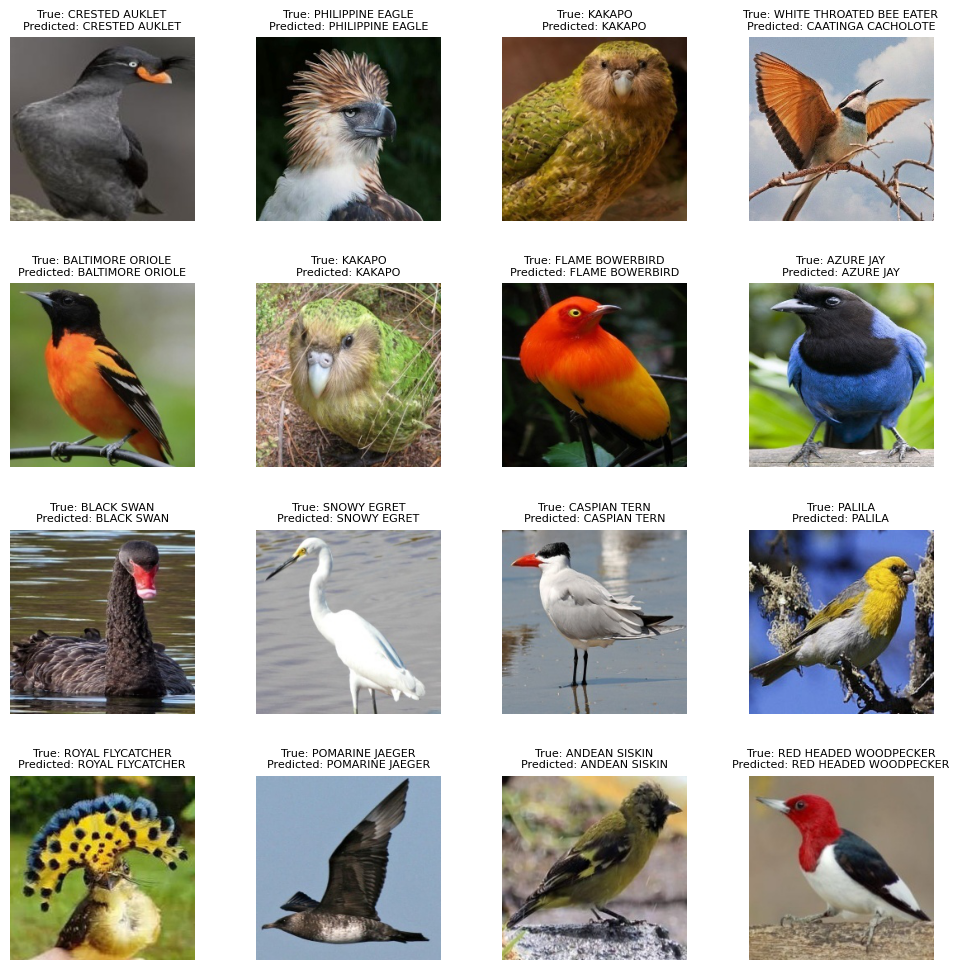

In [163]:
# Predict some sample test images
# Load the saved model
model = models.resnet50(pretrained=False)
num_classes = len(image_datasets['train'].classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load('/content/drive/MyDrive/bird_classification/model.ckpt'))

# Load the test set
test_data = datasets.ImageFolder(
    "/content/drive/MyDrive/bird_classification/data/test", 
    transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True)

# Make predictions for 16 samples
model.eval()
with torch.no_grad():
    images, labels = next(iter(test_loader))
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Display the images with true labels and predicted labels in a 4x4 grid
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
fig.tight_layout()
for i in range(16):
    img = images[i].numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    axs[i // 4, i % 4].imshow(img)
    axs[i // 4, i % 4].axis('off')
    true_label = test_data.classes[labels[i]]
    predicted_label = test_data.classes[predicted[i]]
    axs[i // 4, i % 4].set_title(
        f'True: {true_label}\nPredicted: {predicted_label}',
        fontsize=8)
plt.show()

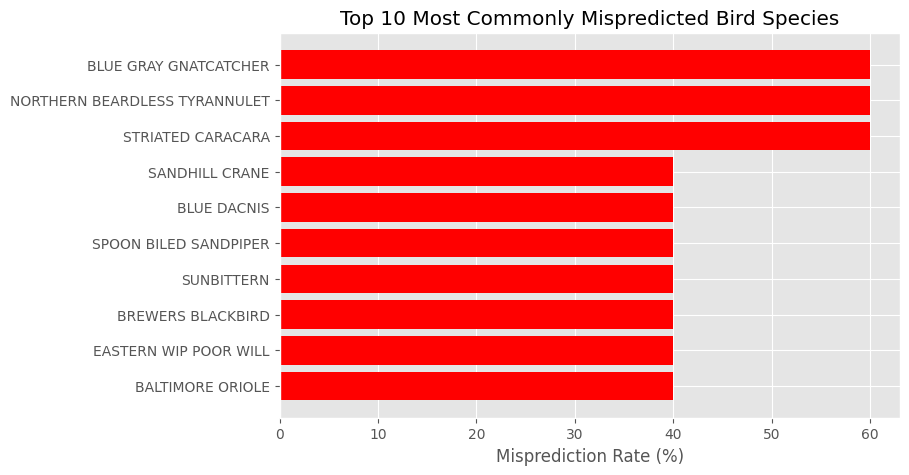

In [172]:
import pandas as pd
import matplotlib.pyplot as plt
# Let's check what are some commonly mislabeled species
# Put the model in eval mode
model.eval()
model.to(device)

# Create lists to store predicted and actual labels
preds = []
labels = []

# Loop over test dataset and make predictions
with torch.no_grad():
    for inputs, targets in dataloaders['test']:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        preds.extend(predicted.cpu().numpy())
        labels.extend(targets.cpu().numpy())

# Create a dataframe with the true and predicted labels
df = pd.DataFrame({'true': labels, 'predicted': preds})

# Get the number of wrong predictions for each class
mispredictions = df[df['true'] != df['predicted']]['true'].value_counts()

# Calculate the misprediction rates for each class
total_images = df['true'].value_counts()
misprediction_rates = 100 * mispredictions / total_images

# Load labels
birds_df = pd.read_csv("/content/drive/MyDrive/bird_classification/data/birds.csv")
name_map = birds_df[["class id", "labels"]].drop_duplicates().set_index("class id").to_dict()


# Get the names of the bird species from the class map
bird_names = [name_map["labels"][i] for i in range(len(name_map["labels"]))]

# Create a dataframe with the misprediction and accuracy rates for each bird species
results_df = pd.DataFrame({'bird_species': bird_names, 'misprediction_rate': misprediction_rates})

# Sort the dataframe by misprediction rate
results_df = results_df.sort_values(by='misprediction_rate', ascending=False)

# Get the top 10 most commonly mispredicted bird species
top_mispredictions = results_df.head(10)

plt.figure(figsize=(8,5))
plt.style.use('ggplot')
# Plot the top 10 most commonly mispredicted bird species
plt.barh(top_mispredictions['bird_species'], top_mispredictions['misprediction_rate'], color='red')
plt.title('Top 10 Most Commonly Mispredicted Bird Species')
plt.xlabel('Misprediction Rate (%)')
plt.gca().invert_yaxis()
plt.show()

Predicted label: 325


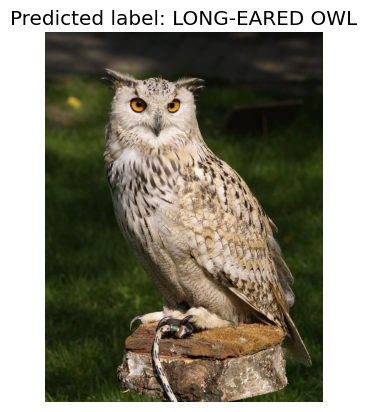

In [174]:
# Now let's test an image from the internet
import requests
from io import BytesIO
import pandas as pd

# URL of the image to predict
image_url = "https://images.pexels.com/photos/53977/eagle-owl-raptor-falconry-owl-53977.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2"

# Get the image from the URL using requests library
response = requests.get(image_url)
raw_image = Image.open(BytesIO(response.content))

# Apply the transform to the image
image = transform(raw_image)

# Add batch dimension to the image tensor
image = image.unsqueeze(0)

# Load the saved model
model = models.resnet50(pretrained=True)
num_classes = len(image_datasets['train'].classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load('/content/drive/MyDrive/bird_classification/model.ckpt'))

# Make a prediction
model.eval()
with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output, 1)

# Print the predicted label
print(f"Predicted label: {predicted.item()}")

# Plot the image
import matplotlib.pyplot as plt
plt.imshow(raw_image)
plt.axis('off')
label_name = name_map["labels"][predicted.item()]
plt.title(f"Predicted label: {label_name}")
plt.show()

# Model Explainability and Interpretation (WIP)

In [175]:
from PIL import Image
import torchvision.transforms.functional as TF
import torch

# Download the image and convert to tensor
url = 'https://images.pexels.com/photos/53977/eagle-owl-raptor-falconry-owl-53977.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2'
response = requests.get(url)
image = Image.open(BytesIO(response.content)).convert('RGB')
tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)


# Resize tensor to input size of model
resize = transforms.Resize((224, 224), antialias=True)
tensor = resize(tensor)

# Convert tensor to numpy array
image_array = tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Create explainer object
explainer = lime_image.LimeImageExplainer()

# Define your model's forward function (assuming model is already loaded and on device)
def predict_fn(images):
    # Convert NumPy array to tensor
    images = torch.from_numpy(images.transpose((0, 3, 1, 2))).to(device)
    state_dict = model.state_dict() # Get the state dict of the model
    conv_weights = state_dict['conv1.weight'] # Get the weights of the first convolutional layer
    conv_bias = state_dict['conv1.bias'] # Get the biases of the first convolutional layer
    outputs = F.conv2d(images, conv_weights, conv_bias, stride=1, padding=0)
    _, preds = torch.max(outputs, 1)
    return preds.cpu().numpy()

# Generate explanations
explanation = explainer.explain_instance(
    image_array,
    predict_fn,
    top_labels=5,
    hide_color=0,
    num_samples=1000,
)

# Print top explanation for each class
for i in range(5):
    print(explanation.top_labels[i], explanation.local_exp[i])

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyError: ignored